In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.9 MB 4.1 MB/s 
     |████████████████████████████████| 462 kB 77.1 MB/s 


In [18]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!nvidia-smi

Thu Apr 21 12:37:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tex
import numpy as np
import pandas as pd
import tensorflow_docs as tfdocs
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Hub version:  0.12.0
GPU is available


In [5]:
df = pd.read_csv ('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                  compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [6]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

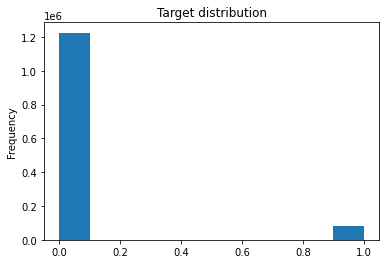

In [8]:
df.target.plot(kind='hist' , title='Target distribution')

In [9]:
small_df, remaining = train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
small_df.shape

(13061, 3)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(small_df['question_text'],small_df['target'], stratify=small_df['target'],train_size=0.8,random_state=10)

In [11]:
X_train.shape , X_test.shape

((10448,), (2613,))

In [12]:
X_train.head()

474381     What is use of the red, blue and green letter ...
1040112    How can I become a marketing consultant in India?
695400      What is the main use of forceps in a laboratory?
876949     What are some memoir, war diary books similar ...
739889     If you want to tell ten things about Shankar N...
Name: question_text, dtype: object

In [13]:
y_train.head()

474381     0
1040112    0
695400     0
876949     0
739889     0
Name: target, dtype: int64

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
EpochDots_cb = tfdocs.modeling.EpochDots()

CALLBACKS_LIST = [early_stopping_cb, EpochDots_cb]


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
      ]

In [43]:
def train_and_evaluate_model(module_url, preprocess_url, name,epoch, trainable=False):

  bert_preprocess_model = hub.KerasLayer(preprocess_url) 
  bert_layer = hub.KerasLayer(module_url, trainable=trainable)

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  preprocessed_text = bert_preprocess_model(text_input)
  outputs = bert_layer(preprocessed_text)

  layer1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  layer2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1)

  model = tf.keras.Model(inputs=[text_input], outputs = [layer2])
  
  model.summary()

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
  
  history = model.fit(
        X_train,
        y_train,
        epochs = epoch,
        validation_data = (X_test, y_test),# validation data is tuple of feature and target
        callbacks = CALLBACKS_LIST,
        verbose=0
    )
  model.evaluate(X_test, y_test)


  return history


In [44]:
histories = {} # module_url,preprocess_url

In [45]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [46]:
histories['bert_en_uncased_L-12_H-768_A-12'] = train_and_evaluate_model(
                                                           module_url, preprocess_url, 
                                                           name='bert_en_uncased_L-12_H-768_A-12',
                                                           epoch = 10,
                                                           trainable=False
                                                                     )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

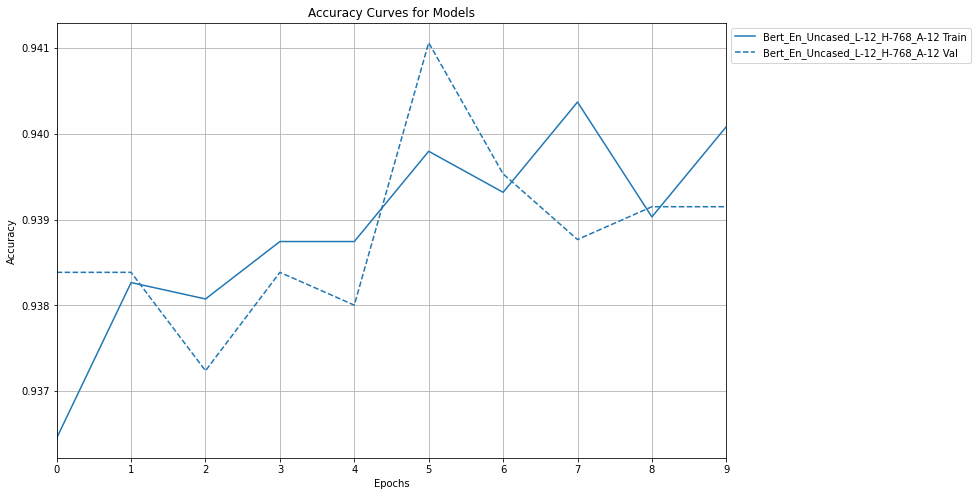

In [47]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [48]:
histories['bert_en_uncased_L-12_H-768_A-12_train=true'] = train_and_evaluate_model(
                                                           module_url, preprocess_url, 
                                                           name='bert_en_uncased_L-12_H-768_A-12',
                                                           epoch = 10,
                                                           trainable=True
                                                                     )

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

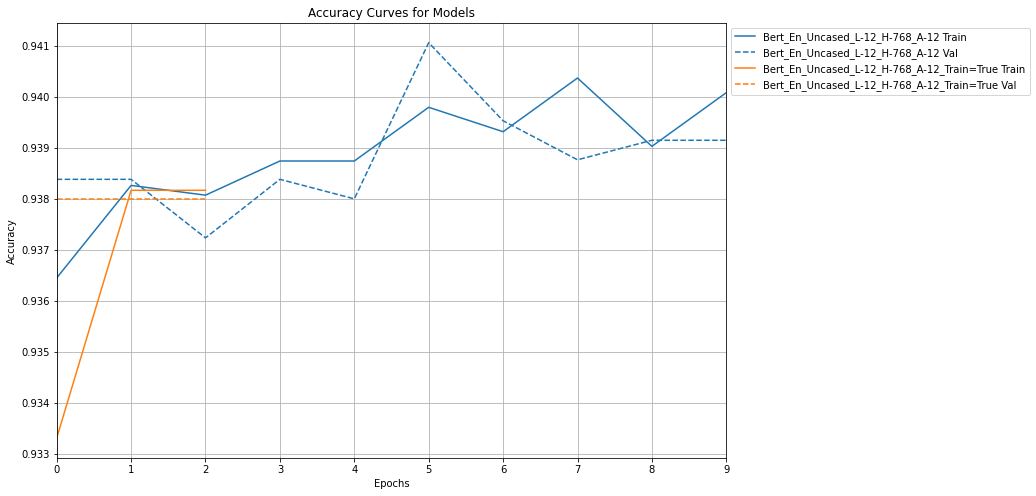

In [49]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [50]:
type(histories['bert_en_uncased_L-12_H-768_A-12_train=true'])

keras.callbacks.History

In [ ]:
histories['bert_en_uncased_L-12_H-768_A-12_train=true']